In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

# Forecasting PJM Daily Energy Demand

This is MW-hour data for a full year. Go to 'Explore data', then inside the pop-up select the data range of interest.
This is a manual workaround while I do not have access to an api. The largest available date range we could pull is 11/1/2016 - current.

Information about the dataset found here: http://dataminer2.pjm.com/feed/hrl_load_metered/definition

<b>TODO</b>: add more background on PJM, power data, etc.

load the data...

In [7]:
df = pd.read_csv('hrl_load_metered (2).csv') #1 year worth of PJM data, woah!!

In [8]:
df.head()

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,11/1/2016 4:00:00 AM,11/1/2016 12:00:00 AM,RFC,MIDATL,AE,AE,849.077,True
1,11/1/2016 4:00:00 AM,11/1/2016 12:00:00 AM,OTHER,OTHER,OTHER,AECO,849.077,True
2,11/1/2016 4:00:00 AM,11/1/2016 12:00:00 AM,RFC,WEST,AEP,AEPAPT,3371.310,True
3,11/1/2016 4:00:00 AM,11/1/2016 12:00:00 AM,RFC,WEST,AEP,AEPIMP,2560.009,True
4,11/1/2016 4:00:00 AM,11/1/2016 12:00:00 AM,RFC,WEST,AEP,AEPKPT,513.897,True


In [9]:
df.load_area.unique()

array(['AE', 'AECO', 'AEPAPT', 'AEPIMP', 'AEPKPT', 'AEPOPT', 'AP', 'BC',
       'CE', 'DAY', 'DEOK', 'DOM', 'DPLCO', 'DUQ', 'EASTON', 'EKPC', 'JC',
       'ME', 'OE', 'PAPWR', 'PE', 'PEPCO', 'PLCO', 'PN', 'PS', 'RECO',
       'SMECO', 'UGI', 'RTO', 'VMEU'], dtype=object)

Focusing on PEPCO for no particular reason, pretty sure it's Potomac Electric Power Company

## Exploring PJM PEPCO data

<b>TODO</b>: put description here of why I'm doing this, things I'm looking for

In [10]:
df_pepco = df[df.load_area=='PEPCO'].reset_index(drop=True)

In [11]:
len(df_pepco)

9265

Confirming 8760 data (number of hours in a full year). Data slightly longer than 1 year.<br>
Check for null values (there are none but just check anyway)

In [12]:
df_pepco.head(2)

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,11/1/2016 4:00:00 AM,11/1/2016 12:00:00 AM,RFC,MIDATL,PEP,PEPCO,2161.229,True
1,11/1/2016 5:00:00 AM,11/1/2016 1:00:00 AM,RFC,MIDATL,PEP,PEPCO,2072.248,True


In [13]:
df_pepco.tail(2)

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
9263,11/22/2017 3:00:00 AM,11/21/2017 10:00:00 PM,RFC,MIDATL,PEP,PEPCO,2500.761,False
9264,11/22/2017 4:00:00 AM,11/21/2017 11:00:00 PM,RFC,MIDATL,PEP,PEPCO,2348.153,False


Turning the date-time stirngs into datetime

In [14]:
df_pepco.mw.describe()

count    9265.000000
mean     2952.843078
std       610.911937
min      1862.649000
25%      2527.855000
50%      2874.353000
75%      3251.465000
max      5363.152000
Name: mw, dtype: float64

In [15]:
df_pepco['dt'] = [datetime.strptime(i,'%m/%d/%Y %I:%M:%S %p') for i in df_pepco.datetime_beginning_utc]

### Visualizing Raw Data

Times are UTC, Looking at 1 day...

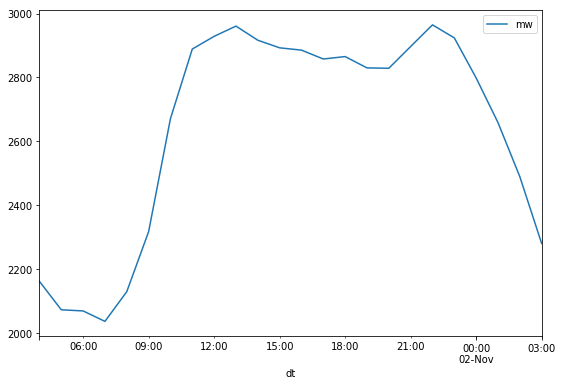

In [16]:
df_pepco[0:24].plot(x='dt',y='mw',figsize=(9,6))

About 1 month...

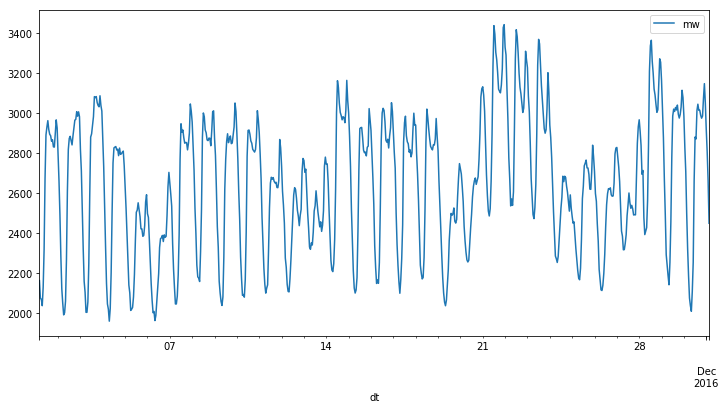

In [17]:
df_pepco[0:720].plot(x='dt',y='mw',figsize=(12,6))

Full dataset (just over 1 year)...

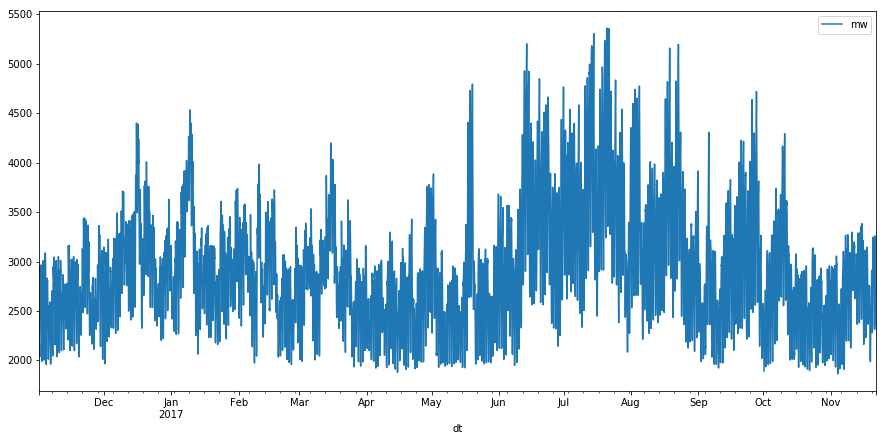

In [18]:
df_pepco.plot(x='dt',y='mw',figsize=(15,7))

There is a *ton* of variation in this data. Given that this is a first cut forecast, I'm going to sum the hourly power values into energy. The timedelta for each data point in our timeseries is 1 hour, and we have avergage MW values for the period. Therefore, each value is both an average power value ($\bar{MW}$) and an energy value, $MWh$. <br>

Note: this assumes the avg. hourly power value is an accurate representation of the power flow during the time interval. Typically interval data consists of power values averaged over 15-minute periods (as opposed to 1 hour), so our resolution here isn't great.

In [19]:
df_resamp = df_pepco.set_index('dt',drop=True).resample('D').sum() #total daily energy

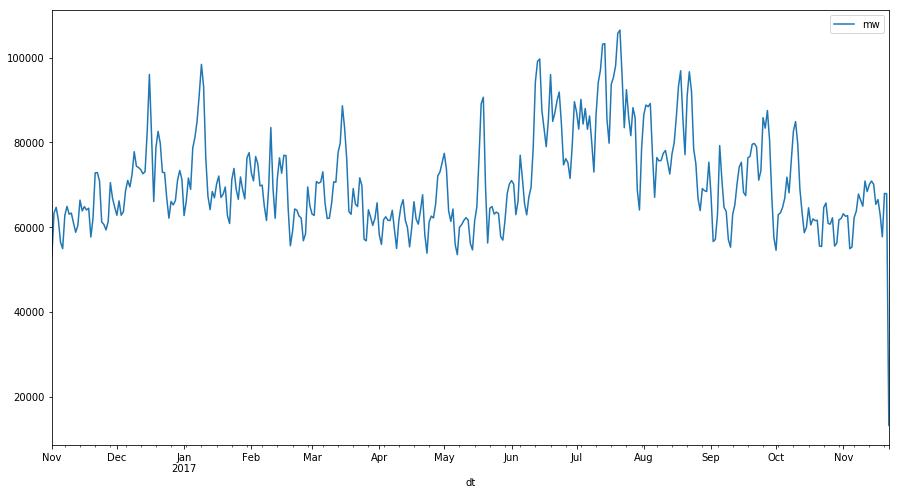

In [20]:
df_resamp.plot(use_index=True,y='mw',figsize=(15,8))

Out of curiosity, how does the energy consumption compare per month

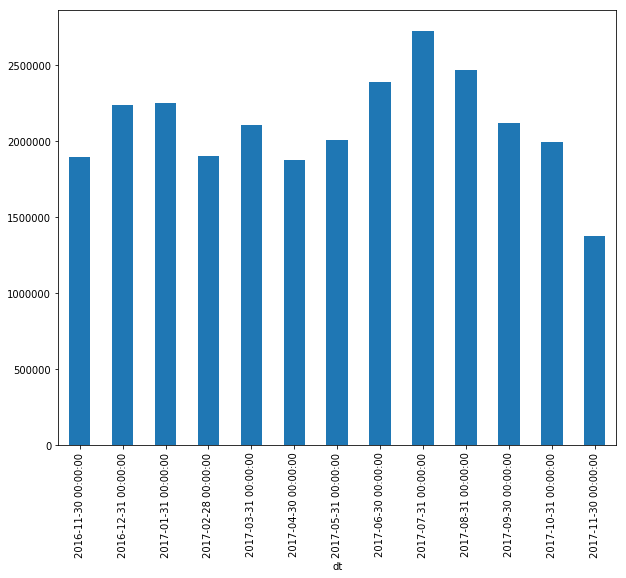

In [21]:
df_pepco.set_index('dt',drop=True).resample('1m').mw.sum().plot(kind='bar',figsize=(10,8)) #monthly sum

## Time Series Forecast

Method here will be to forecast the some of the data in our PJM PEPCO dataset. Using the following resources as a guide:
* http://www.saedsayad.com/docs/Time%20Series%20and%20Forecasting.pdf
* https://datascience.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c
* https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/

Some of my conerns at the outset are that the dataset contains a lot of variation when looking at the hourly data. I'm not sure if the model will be able to handle this, we'll see. I have have to resample the data by H > D > W > M and check the results.

### Stationary data

In order build a time series model, we must first ensure the data is stationary. We must do this because the statistical models used (i.e. regression) employs a fundamental assumption that the underlying data is made of independent random variables. Now we know our dataset is time-dependent, however stationary random data can be used in place.

To qualify as a 'stationary' series, a set of data must obey the following:
1. Trend: The mean of the series must not be a function of time. You can tell if the mean is a function of time with a simple visualization of your data - if you notice a clear upward or downward trend, the dataset is not stationary.
2. Homoscedasticity: The variance of the series must not be a function of time. 
3. Covariance: The measure by which two variables vary (or move) together. 

Excellent depiction of the assumptions above found here: http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/ <br>

In our application, we're on the look-out and will aim to resolve two main criteria:

1. Trend: upward (or downward) changes to mean energy demand over time
2. Seasonality: periodic changes to energy demand in specific time-intervals. One pretty obvious hpyothesis here is that we'll see clear 'seasonality' on a 7-day basis, with high energy demand during the weekdays, lower during the weekend, and repeat.

First, I'm going toremove the Nov 2017 values from the timeseries data. I will use the bulk data to build the model and try to forecast the mean daily power values for the excluded values: 11/1/2017 - 11/22/2017 (didn't actually do this...)

In [22]:
train = df_resamp.mw[0:-1] # the last day is not a full days worth of data

In [23]:
train

dt
2016-11-01    53096.021
2016-11-02    63301.353
2016-11-03    64686.615
2016-11-04    61760.845
2016-11-05    56505.973
2016-11-06    54943.868
2016-11-07    62796.029
2016-11-08    64900.299
2016-11-09    63068.163
2016-11-10    63329.371
2016-11-11    60991.036
2016-11-12    58806.499
2016-11-13    60397.782
2016-11-14    66386.594
2016-11-15    63836.917
2016-11-16    64859.403
2016-11-17    64059.375
2016-11-18    64476.284
2016-11-19    57675.291
2016-11-20    62135.533
2016-11-21    72804.465
2016-11-22    72870.129
2016-11-23    70881.693
2016-11-24    61243.544
2016-11-25    60652.013
2016-11-26    59358.266
2016-11-27    61351.728
2016-11-28    70515.222
2016-11-29    66827.191
2016-11-30    64695.593
                ...    
2017-10-23    64666.701
2017-10-24    65712.795
2017-10-25    60886.546
2017-10-26    60717.112
2017-10-27    62218.347
2017-10-28    55560.136
2017-10-29    56228.184
2017-10-30    61744.020
2017-10-31    62049.168
2017-11-01    63163.702
2017-11-02   

To evaulate whether our dataset if stationary, we can employ a visual check and the Dicky-Fuller test (https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)<br>

In [24]:
def stationary_check(tsdata):
    fig,ax = plt.subplots(2,1,figsize=(13,6),sharex=True)
    ax[0].plot(tsdata,'y',label='hourly power data');
    ax[0].plot(pd.rolling_mean(tsdata,window=int(len(tsdata)/50),center=False),'k',label='rolling mean');
    ax[0].legend()
    ax[1].plot(pd.rolling_std(tsdata,window=int(len(tsdata)/50),center=False),'b',label='rolling standard deviation');
    ax[1].legend()
    dicky_fuller = adfuller(tsdata, autolag='AIC')
    dicky_fuller_res = pd.Series(dicky_fuller[0:4],
                             index=['t-statistic','p-value','num of lags','num of observations'])
    for k,v in dicky_fuller[4].items():
        dicky_fuller_res['critical value: {0}'.format(k)] = v
    return dicky_fuller_res, plt

t-statistic             -2.457072
p-value                  0.126271
num of lags             15.000000
num of observations    370.000000
critical value: 5%      -2.869383
critical value: 1%      -3.448148
critical value: 10%     -2.570948
dtype: float64


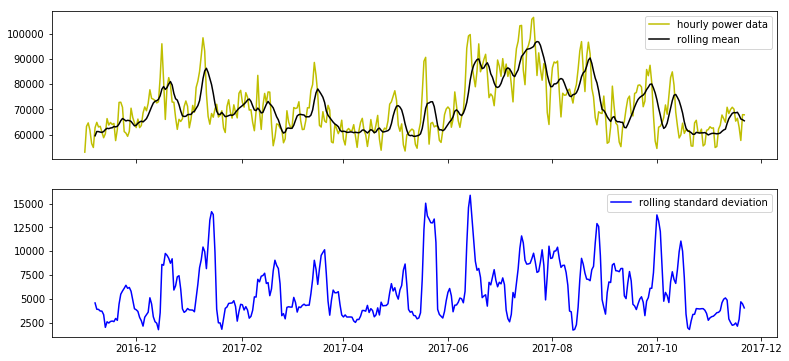

In [25]:
df, f = stationary_check(train)
print (df)

The timeseries data *is not* stationary:
* visual check fails, mean varies, deviation time dependant
* p-value > 0.05
* t-statistic > critical value at 1%

Comment on this data - we need to make this data stationary.

### Perform a log transform on the timeseries data 

Comment on why we perform a log transform and what that helps remove

t-statistic             -2.457920
p-value                  0.126051
num of lags             15.000000
num of observations    370.000000
critical value: 5%      -2.869383
critical value: 1%      -3.448148
critical value: 10%     -2.570948
dtype: float64


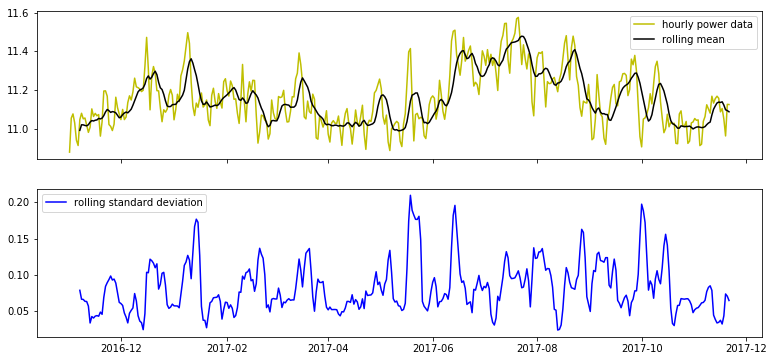

In [26]:
train_log = np.log(train)
df, f = stationary_check(train_log)
print (df)

The timeseries data still not stationary:
* p-value > 0.05
* t-statistic > critical value at 1%

Comment on this data.<br>

Next step is to try to eliminate the trend and seasonality of the dataset. We can use the *seasonal_decompose* package from the *statsmodel* library for this:

### Option A - eliminate trend and seasonality using decomposition

In [194]:
decomp = seasonal_decompose(train_log,model='additive')

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

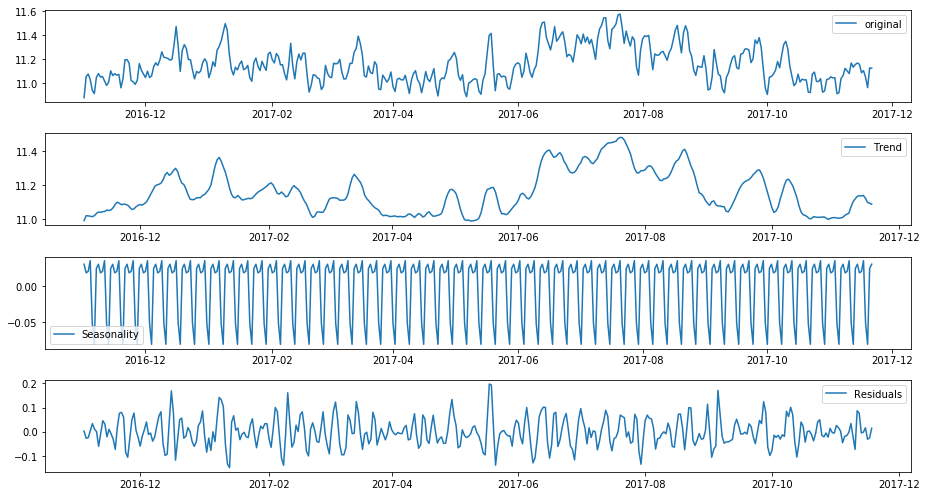

In [195]:
fig,ax = plt.subplots(4,1,figsize=(13,7))
ax[0].plot(train_log.index, train_log.values,label='original')
ax[0].legend()
ax[1].plot(train_log.index, trend.values, label='Trend')
ax[1].legend()
ax[2].plot(train_log.index, seasonal.values,label='Seasonality')
ax[2].legend()
ax[3].plot(train_log.index, residual.values, label='Residuals')
ax[3].legend()
plt.tight_layout()

Notes on trend: definitely see overall increased energy usage duringt the summer time. There are spikes throughout the year (releative to a low baseline in the spring around April). I would guess these are either weather or holiday related, where holidays. <br>

Notes on seasonality: crystal clear seasonality every 7 days (weekly).

The decomp function removes trend and seasonality, leaving us with the residual to model:

t-statistic           -8.627529e+00
p-value                5.875049e-14
num of lags            1.700000e+01
num of observations    3.620000e+02
critical value: 5%    -2.869557e+00
critical value: 1%    -3.448544e+00
critical value: 10%   -2.571041e+00
dtype: float64


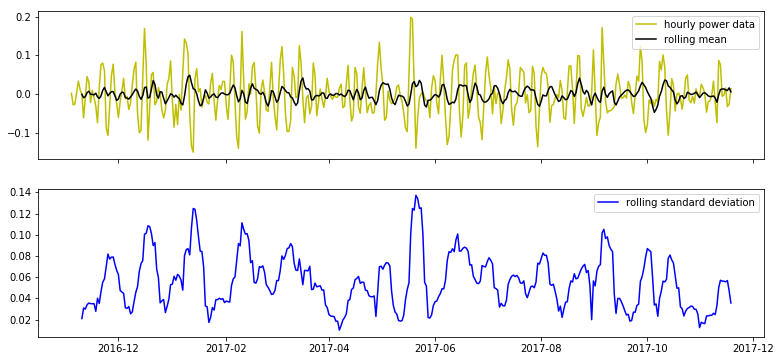

In [36]:
train_log_decomp = residual
train_log_decomp.dropna(inplace=True)
df, f = stationary_check(train_log_decomp)
print (df)

From the Dickey–Fuller test, we now have a stationary timeseries dataset. Our t-statistic is well below the critical value and our p-value is well below 0.05. 

Good outline on what the decomp does here: http://www.cbcity.de/timeseries-decomposition-in-python-with-statsmodels-and-pandas

### Option B - Difference the data to remove trend and seasonality

Another very common and effective way to elimiante seasonality and trend is by differencing. Good documentation here: https://machinelearningmastery.com/difference-time-series-dataset-python/. Pandas has a convient function *shift* that allows us to perform this simply. This differencing technique will subtract the previous energy value from the subsequent value in the series ($E_d = E_1 - E_0$)

t-statistic           -7.453497e+00
p-value                5.590289e-11
num of lags            1.400000e+01
num of observations    3.700000e+02
critical value: 5%    -2.869383e+00
critical value: 1%    -3.448148e+00
critical value: 10%   -2.570948e+00
dtype: float64


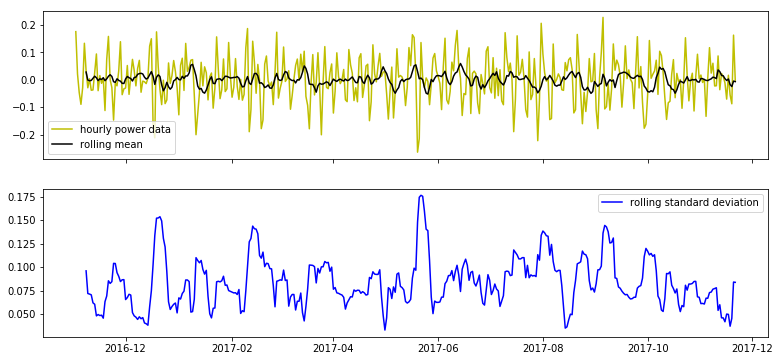

In [37]:
train_log_diff = train_log - train_log.shift()
train_log_diff.dropna(inplace=True)
df,f = stationary_check(train_log_diff)
print (df)

We can confidently say our timeseries data is stationary. Our p-value is well below the 0.05 alpha value and the t-statistics is well below the critical 1% value

## Autoregressive Integrated Moving Average (ARIMA)

Using the ARIMA model on the stationary time series data.

The ARIMA model needs three parameters:

1. p: the autoregression (AR) term. This is the number of 'lag' terms, or how many previous variables will be used to predict the current value.
2. q: the moving-averge (MA) term. This is the number of 'lag' error terms, or how many previous error terms will be used to predict the current value. The error term is the difference between the moving average value and the actual value at each given time.
3. d: the difference term. This is the number of non-seasonal differences. In the case above, we took a first order difference so our d will be 1. 

Here are some excellent resources:
* understanding how everything fits together: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
* understanding the ARIMA model: https://people.duke.edu/~rnau/411arim.htm 
* understanding the difference term: https://people.duke.edu/~rnau/411diff.htm

Now, in order to find the best *p* and *q* parameters for the ARIMA model, we can use the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to help guide our decision.

Good resource on ACF and PACF:
* https://onlinecourses.science.psu.edu/stat510/node/64

In [91]:
lag_acf = acf(train_log_diff, nlags=40)
lag_pacf = pacf(train_log_diff, nlags=40, method='ols')

In [92]:
def plot_cf(acf,pacf):
    fig,ax = plt.subplots(1,2,figsize=(15,6))
    ax[0].plot(acf,'-o',label='ACF')
    ax[0].axhline(y=0,linestyle='--',color='gray')
    ax[0].axhline(y=-1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
    ax[0].axhline(y=1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
    ax[0].legend()
    ax[1].plot(pacf,'-o',label='PACF')
    ax[1].axhline(y=0,linestyle='--',color='gray')
    ax[1].axhline(y=-1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
    ax[1].axhline(y=1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
    ax[1].legend()
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

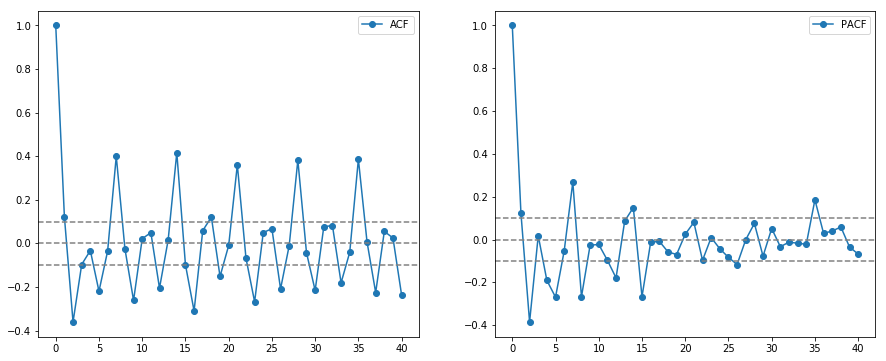

In [93]:
plot_cf(lag_acf,lag_pacf)

Another way to view this:

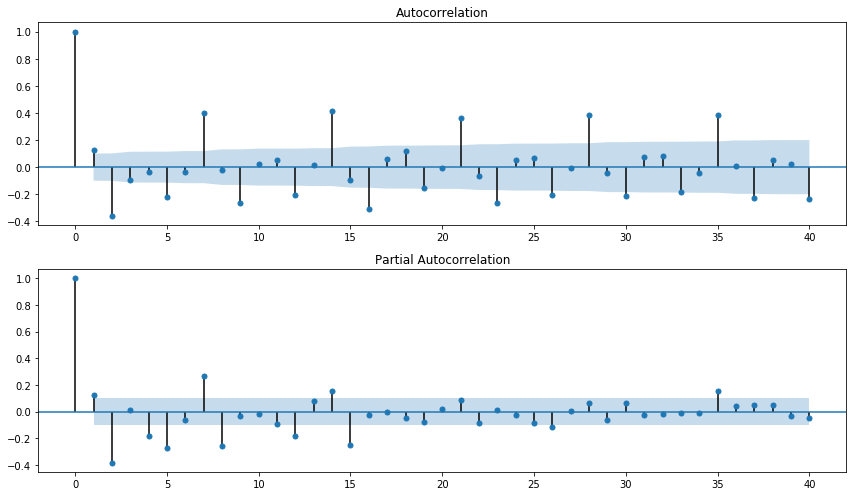

In [94]:
fig, ax = plt.subplots(2,1,figsize=(12,7))
plot_acf(train_log_diff, lags=40,ax=ax[0]);
plot_pacf(train_log_diff, lags=40,ax=ax[1]);
plt.tight_layout()

We still have very high autocorrelation at high number of lags (outside the confidence interval ~40 lags..). To resolve this we can try to take another higher order difference.

<b> One order difference *along* on the timeseries will not be enough to resolve the seasonality and trend components on the data, despite passing the dicky-fuller test.</b>
    
### Experimenting with ACF and PACF

Below I try to increaes the order of differencing, and combine the decomposition component. Starting first with a second order difference:

t-statistic           -9.133923e+00
p-value                2.970763e-15
num of lags            1.500000e+01
num of observations    3.680000e+02
critical value: 5%    -2.869426e+00
critical value: 1%    -3.448245e+00
critical value: 10%   -2.570971e+00
dtype: float64


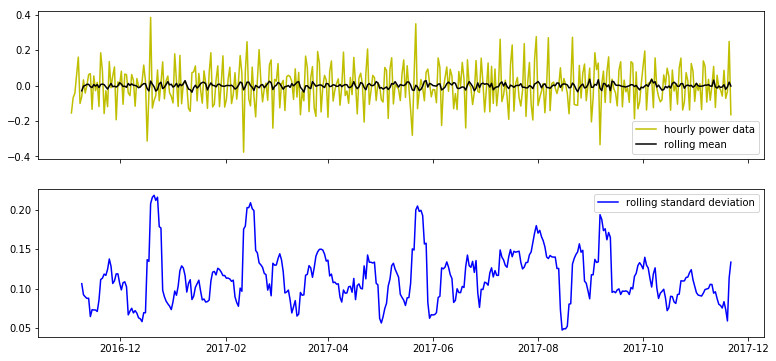

In [77]:
train_log_diff2 = train_log_diff - train_log_diff.shift()
train_log_diff2.dropna(inplace=True)
df,f = stationary_check(train_log_diff2)
print (df)

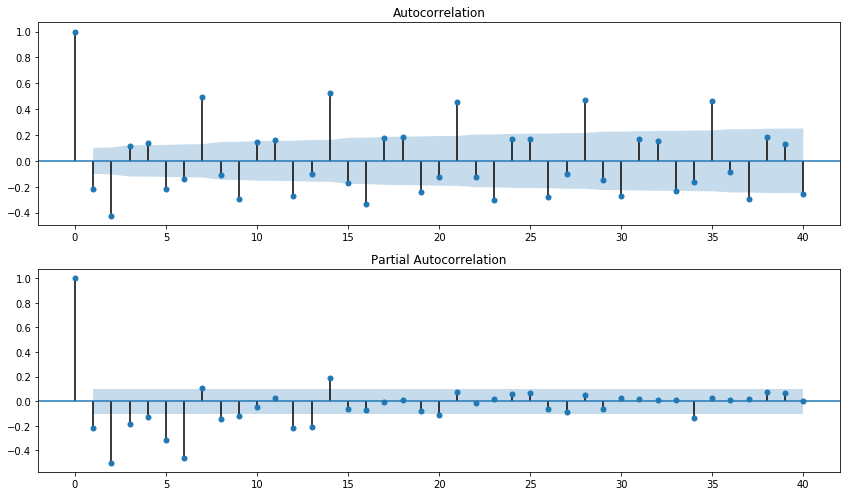

In [81]:
fig, ax = plt.subplots(2,1,figsize=(12,7))
plot_acf(train_log_diff2, lags=40,ax=ax[0]);
plot_pacf(train_log_diff2, lags=40,ax=ax[1]);
plt.tight_layout()

Still seeing AC outside the confidence bounds. Let's try a third order difference...

t-statistic           -1.111090e+01
p-value                3.662420e-20
num of lags            1.600000e+01
num of observations    3.660000e+02
critical value: 5%    -2.869469e+00
critical value: 1%    -3.448344e+00
critical value: 10%   -2.570994e+00
dtype: float64


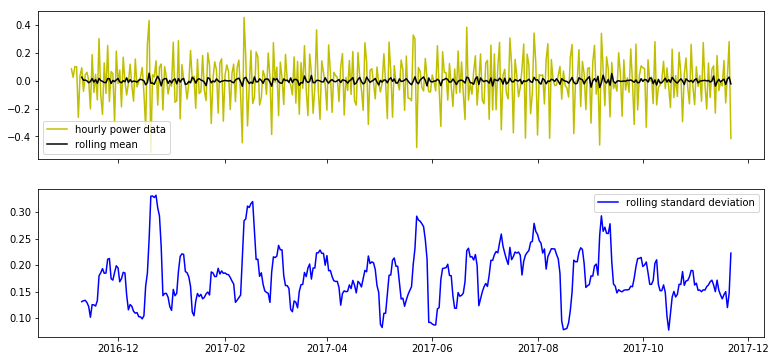

In [82]:
train_log_diff3 = train_log_diff2 - train_log_diff2.shift()
train_log_diff3.dropna(inplace=True)
df,f = stationary_check(train_log_diff3)
print (df)

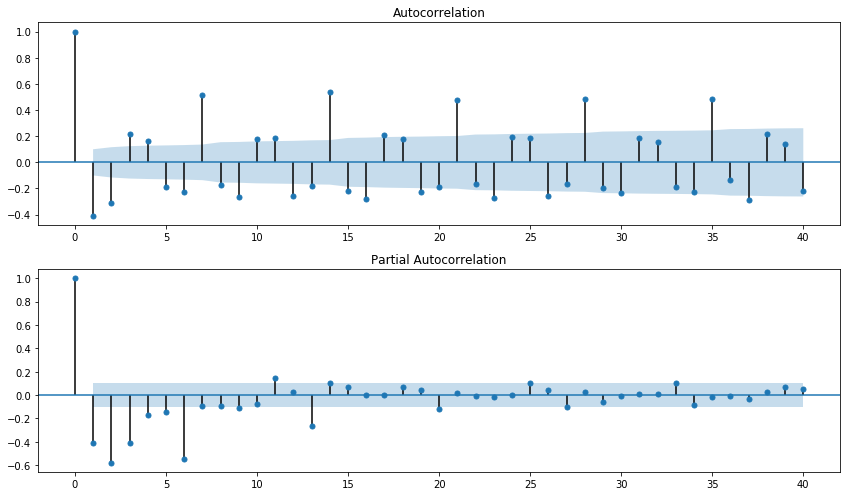

In [83]:
fig, ax = plt.subplots(2,1,figsize=(12,7))
plot_acf(train_log_diff3, lags=40,ax=ax[0]);
plot_pacf(train_log_diff3, lags=40,ax=ax[1]);
plt.tight_layout()

Still no improvement, actually looks like it may be getting worse. Let's try plotting ACF and PACF on the decomposition timeseries:

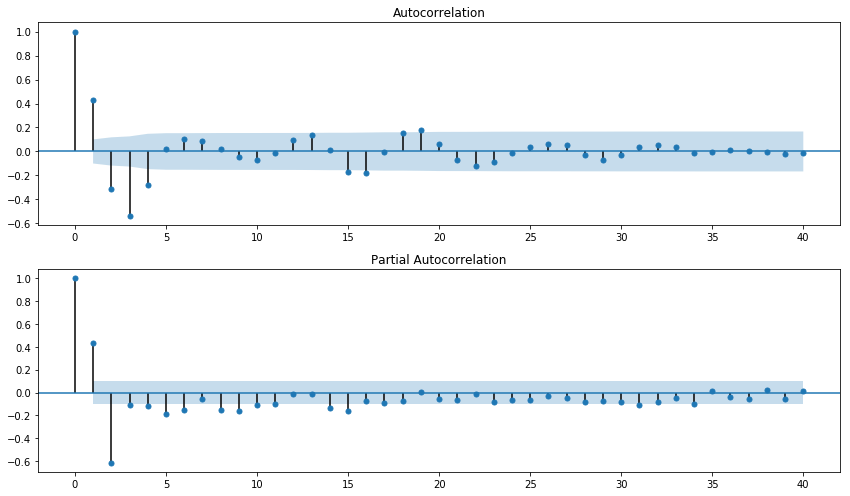

In [84]:
fig, ax = plt.subplots(2,1,figsize=(12,7))
plot_acf(train_log_decomp, lags=40,ax=ax[0]);
plot_pacf(train_log_decomp, lags=40,ax=ax[1]);
plt.tight_layout()

Looks promising, let's try taking a difference on the decompositioned data:

t-statistic           -1.041647e+01
p-value                1.749186e-18
num of lags            1.700000e+01
num of observations    3.610000e+02
critical value: 5%    -2.869580e+00
critical value: 1%    -3.448595e+00
critical value: 10%   -2.571053e+00
dtype: float64


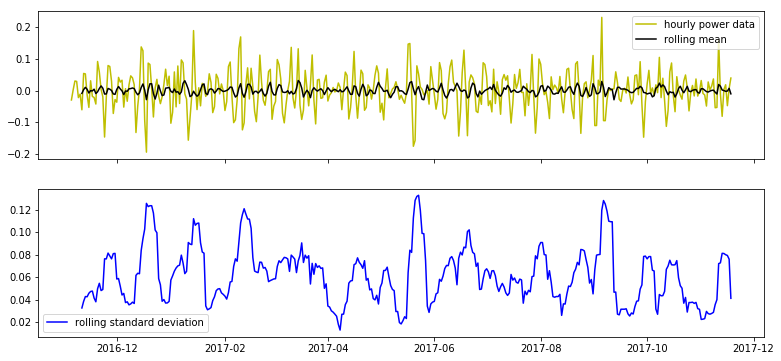

In [86]:
train_log_decomp_diff = train_log_decomp - train_log_decomp.shift()
train_log_decomp_diff.dropna(inplace=True)
df,f = stationary_check(train_log_decomp_diff)
print (df)

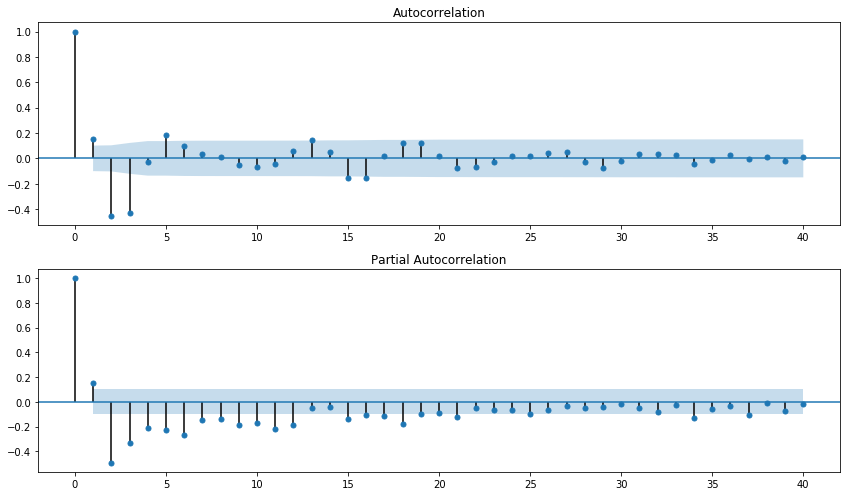

In [87]:
fig, ax = plt.subplots(2,1,figsize=(12,7))
plot_acf(train_log_decomp_diff, lags=40,ax=ax[0]);
plot_pacf(train_log_decomp_diff, lags=40,ax=ax[1]);
plt.tight_layout()

In [90]:
res = arma_order_select_ic(train_log_decomp, ic=['aic', 'bic'])
print (res.aic_min_order)
print (res.bic_min_order)

(4, 1)
(2, 2)


In [184]:
model = ARIMA(train_log_decomp, order=(5, 0, 1))  
results_ARIMA = model.fit(disp=0)

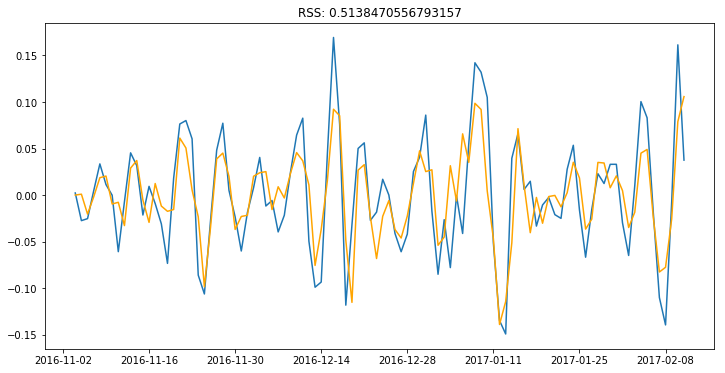

In [216]:
fig,ax=plt.subplots(figsize=(12,6))
ax.plot(train_log_decomp[0:100])
ax.plot(results_ARIMA.fittedvalues[0:100], color='orange')
ax.set_title('RSS: {0}'.format(sum((results_ARIMA.fittedvalues - train_log_decomp).dropna()**2)));

                              ARMA Model Results                              
Dep. Variable:                     mw   No. Observations:                  380
Model:                     ARMA(5, 1)   Log Likelihood                 714.743
Method:                       css-mle   S.D. of innovations              0.037
Date:                Sun, 26 Nov 2017   AIC                          -1413.485
Time:                        13:27:51   BIC                          -1381.964
Sample:                    11-04-2016   HQIC                         -1400.978
                         - 11-18-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.016e-05   5.26e-05      0.384      0.701   -8.28e-05       0.000
ar.L1.mw       1.3805      0.051     27.062      0.000       1.280       1.480
ar.L2.mw      -1.0648      0.087    -12.197      0.0

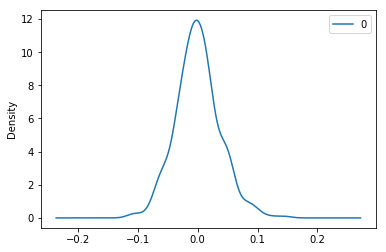

In [186]:
print (results_ARIMA.summary())
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

Need to add back the trend and seasonal components of the data. Recall we modelled on the residual of the decomp after isolating the trend and seasonality components. Let's see if this works..

In [201]:
p_decomp = pd.Series(results_ARIMA.fittedvalues).copy()
p_log = p_decomp + trend + seasonal.values
p_act = np.exp(p_log)

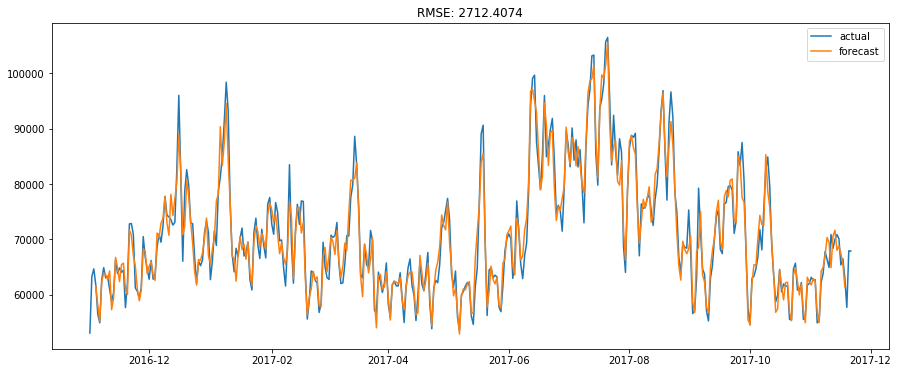

In [218]:
fig,ax = plt.subplots(figsize=(15,6))
ax.plot(train.index, train.values, label='actual')
ax.plot(train.index, p_act.values,label='forecast')
ax.set_title('RMSE: %.4f'% np.sqrt(sum((p_act-train).dropna()**2)/len(train)));
ax.legend()

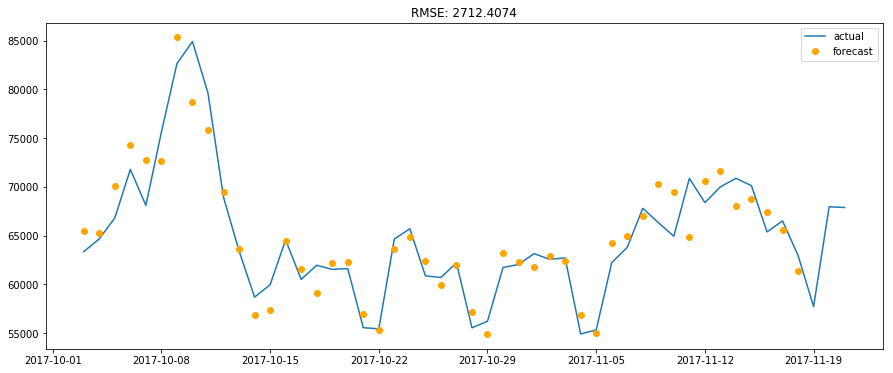

In [227]:
fig,ax = plt.subplots(figsize=(15,6))
ax.plot(train.index[-50:], train.values[-50:], label='actual')
ax.plot(train.index[-50:], p_act.values[-50:], 'o',c='orange', label='forecast')
ax.set_title('RMSE: %.4f'% np.sqrt(sum((p_act-train).dropna()**2)/len(train)));
ax.legend()

Note:<br> 
* the forecast() function is an array containing the forecast value, the standard error of the forecast, and the confidence interval information
* I need to find a way to split the data such that I'm modelling on train data, then using the forecast function to come up with future values. I can compare these future values with the actual data
* will need to create a program to loop through different ARIMA parameters that will minimize some value (ex. min RMSE)

below not working, will come back to this....

In [264]:
len(history)

367

In [267]:
model = ARIMA(train_log_decomp, order=(5,0,1), freq='D')
model_fit = model.fit(disp=0)

In [272]:
size = int(len(train_log_decomp) - 10) #remove the last 21 days from the historical data
train_, test_ = train_log_decomp[0:size], train_log_decomp[size:len(train_log_decomp)] #split the data into test and train
history = [x for x in train_]
predictions = list() #initializing list for our prediction values

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test_)):
    try: 
        model = ARIMA(history, order=(5,0,1))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(float(yhat))
        obs = test_[t]
        history.append(obs)
        print('predicted={0}, expected={1}'.format(np.exp(yhat), np.exp(obs)))
    except Exception as e:
        print (e)
        pass
predictions_series = pd.Series(predictions, index = test_.index)

Printing Predicted vs Expected Values...


predicted=[ 1.03958777], expected=0.9798323188654171
predicted=[ 0.99452725], expected=0.9291129542348648
predicted=[ 0.99646097], expected=1.090652231589741
predicted=[ 1.11483263], expected=1.0789785799867357
predicted=[ 1.01880588], expected=0.9948060456409487
predicted=[ 0.95633609], expected=0.997761434575352
predicted=[ 0.99657541], expected=1.0161189301780151
predicted=[ 0.99935045], expected=0.968830332631242
predicted=[ 0.95955369], expected=0.9749109664089378
predicted=[ 0.98871088], expected=1.0140212558049742


#### old model using the difference and not decompisition<br>
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(train_log.iloc[0], index=train_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(train.index, train.values)
plt.plot(train.index, predictions_ARIMA.values)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-train)**2)/len(train)))

Text(0.5,1,'RMSE: 39714.7121')

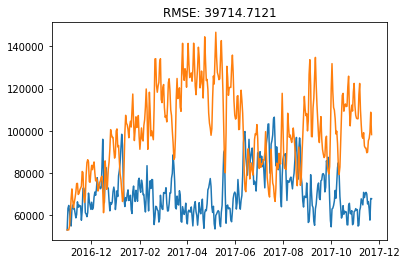

In [690]:
#old model using the difference and not decompisition<br>
size = int(len(train_log_diff) - 21)
train_, test_ = train_log_diff[0:size], train_log_diff[size:len(train_log_diff)+1]
history = [x for x in train_]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test_)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=-1)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test_[t]
    history.append(obs)
    print('predicted={0}, expected={1}'.format(np.exp(yhat), np.exp(obs)))
predictions_series = pd.Series(predictions, index = test.index)

In [ ]:
#old model using the difference and not decompisition<br>
fig, ax = plt.subplots()
ax.set(title='PJM Daily Energy Demand', xlabel='Date', ylabel='Energy, MWh')
ax.plot(train[-50:], 'o', label='observed')
ax.plot(predictions_series.index,np.exp(predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')

In [167]:
#no major improvement can be seen here with the addition of the SAR term, ignoring for now
model_sar = SARIMAX(train_log_decomp, order=(2, 0, 2),seasonal_order=(0,0,0,7))  
results_SARIMAX = model_sar.fit(disp=0)
fig,ax=plt.subplots(figsize=(12,6))
ax.plot(train_log_decomp[0:100])
ax.plot(results_SARIMAX.fittedvalues[0:100], color='red')
ax.set_title('RSS: {0}'.format(sum((results_SARIMAX.fittedvalues - train_log_decomp).dropna()**2)));